In [1]:
"""
Mobile robot motion planning sample with Dynamic Window Approach
author: Atsushi Sakai (@Atsushi_twi)
"""
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from Referee.ICRAMap import BORDER_POS, BORDER_BOX

show_animation = True

In [97]:
class Config():
    # simulation parameters

    def __init__(self):
        # robot parameter
        self.max_speed = 1.0  # [m/s]
        self.min_speed = -0.5  # [m/s]
        self.max_yawrate = 40.0 * math.pi / 180.0  # [rad/s]
        self.max_accel = 0.2  # [m/ss]
        self.max_dyawrate = 40.0 * math.pi / 180.0  # [rad/ss]
        self.v_reso = 0.01  # [m/s]
        self.yawrate_reso = 0.1 * math.pi / 180.0  # [rad/s]
        self.dt = 0.1  # [s]
        self.predict_time = 3.0  # [s]
        self.to_goal_cost_gain = 100.0
        self.speed_cost_gain = 1.0
        self.robot_radius = 0.25  # [m]


def motion(x, u, dt):
    # motion model

    x[2] += u[1] * dt
    x[0] += u[0] * math.cos(x[2]) * dt
    x[1] += u[0] * math.sin(x[2]) * dt
    x[3] = u[0]
    x[4] = u[1]

    return x


def calc_dynamic_window(x, config):

    # Dynamic window from robot specification
    Vs = [config.min_speed, config.max_speed,
          -config.max_yawrate, config.max_yawrate]

    # Dynamic window from motion model
    Vd = [x[3] - config.max_accel * config.dt,
          x[3] + config.max_accel * config.dt,
          x[4] - config.max_dyawrate * config.dt,
          x[4] + config.max_dyawrate * config.dt]

    #  [vmin,vmax, yawrate min, yawrate max]
    dw = [max(Vs[0], Vd[0]), min(Vs[1], Vd[1]),
          max(Vs[2], Vd[2]), min(Vs[3], Vd[3])]

    return dw


def calc_trajectory(xinit, v, y, config):

    x = np.array(xinit)
    traj = np.array(x)
    time = 0
    while time <= config.predict_time:
        x = motion(x, [v, y], config.dt)
        traj = np.vstack((traj, x))
        time += config.dt

    return traj


def calc_final_input(x, u, dw, config, goal, ob):

    xinit = x[:]
    min_cost = 10000.0
    min_u = u
    min_u[0] = 0.0
    best_traj = np.array([x])
    record = []

    # evalucate all trajectory with sampled input in dynamic window
    for v in np.arange(dw[0], dw[1], config.v_reso):
        for y in np.arange(dw[2], dw[3], config.yawrate_reso):
            traj = calc_trajectory(xinit, v, y, config)

            # calc cost
            to_goal_cost = calc_to_goal_cost(traj, goal, config)
            speed_cost = config.speed_cost_gain * \
                (config.max_speed - traj[-1, 3])
            ob_cost = calc_obstacle_cost(traj, ob, config)
            #print("ob cost: {}".format(ob_cost))

            final_cost = to_goal_cost + speed_cost + ob_cost

            #print (to_goal_cost, speed_cost, final_cost)

            # search minimum trajectory
            if min_cost >= final_cost:
                min_cost = final_cost
                min_u = [v, y]
                best_traj = traj
                record = [to_goal_cost, speed_cost, ob_cost]
                
    print(record)

    return min_u, best_traj


def calc_obstacle_cost(traj, ob, config):
    # calc obstacle cost inf: collistion, 0:free

    skip_n = 2
    minr = float("inf")

    for ii in range(0, len(traj[:, 1]), skip_n):
        x = int(traj[ii, 0]*10)
        y = int(traj[ii, 1]*10)
        ox, oy = ob[y, x]
        dx = (traj[ii, 0]) - ox
        dy = (traj[ii, 1]) - oy
        #r = np.hypot(dx, dy)
        r = math.sqrt(dx**2 + dy**2)
        if r <= config.robot_radius:
            #print("r: {}".format(r))
            return float("Inf")  # collision
        if minr >= r:
            minr = r
        '''
        for i in range(len(ob[:, 0])):
            ox = ob[i, 0]
            oy = ob[i, 1]
            dx = traj[ii, 0] - ox
            dy = traj[ii, 1] - oy

            r = math.sqrt(dx**2 + dy**2)
            if r <= config.robot_radius:
                print("r: {}".format(r))
                return float("Inf")  # collision

            if minr >= r:
                minr = r
        '''

    #print("minr: {}".format(minr))
    return 1.0 / minr  # OK


def calc_to_goal_cost(traj, goal, config):
    # calc to goal cost. It is 2D norm.

    #goal_magnitude = math.sqrt(goal[0]**2 + goal[1]**2)
    #traj_magnitude = math.sqrt(traj[-1, 0]**2 + traj[-1, 1]**2)
    #dot_product = (goal[0] * traj[-1, 0]) + (goal[1] * traj[-1, 1])
    #error = dot_product / (goal_magnitude * traj_magnitude)
    #error_angle = math.acos(error)
    #cost = config.to_goal_cost_gain * error_angle
    cost = config.to_goal_cost_gain * math.sqrt(
        (goal[0]-traj[-1, 0])**2 + (goal[1]-traj[-1, 1])**2)

    return cost


def dwa_control(x, u, config, goal, ob):
    # Dynamic Window control

    dw = calc_dynamic_window(x, config)

    u, traj = calc_final_input(x, u, dw, config, goal, ob)

    return u, traj


def plot_arrow(x, y, yaw, length=0.5, width=0.1):  # pragma: no cover
    plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
              head_length=width, head_width=width)
    plt.plot(x, y)

def calc_repulsive_potential(x, y, ox, oy, rr):
    # search nearest obstacle
    minid = -1
    dmin = float("inf")
    for i, _ in enumerate(ox):
        #d = np.hypot(x - ox[i], y - oy[i])
        d = math.sqrt((x - ox[i])**2 + (y - oy[i])**2)
        if dmin >= d:
            dmin = d
            minid = i

    # calc repulsive potential
    #dq = np.hypot(x - ox[minid], y - oy[minid])
    return np.array([ox[minid], oy[minid]])


In [3]:
class DynamicWindow():
    def __init__(self):
        #ob = [[-1, -1]]
        ox = []
        oy = []
        for (x, y), (w, h) in zip(BORDER_POS, BORDER_BOX):
            for i in np.arange(x-w, x+w, 0.1):
                for j in np.arange(y-h, y+h, 0.1):
                    ox.append(i)
                    oy.append(j)
        ob = np.zeros([50, 80, 2])
        for ix in range(80):
            x = ix / 10
            for iy in range(50):
                y = iy / 10
                ob[iy, ix] = calc_repulsive_potential(x, y, ox, oy, 0.25)
        plt.imshow(ob[:,:,1])
        plt.show()
        self.ob = ob
        self.config = Config()

    def moveTo(self, action, pos, vel, angle, goal):
        vel = math.sqrt(vel[0]**2+vel[1]**2)
        x = np.array([pos[0], pos[1], angle, vel, 0.0])
        u = np.array([vel, 0.0])
        u, ltraj = dwa_control(x, u, self.config, goal, self.ob)
        print(pos, goal, u)
        action[0] = u[0]*2
        action[1] = u[1]*2
        return action



In [4]:
def main(gx, gy, ob):
    print(__file__ + " start!!")
    # initial state [x(m), y(m), yaw(rad), v(m/s), omega(rad/s)]
    x = np.array([0.5, 0.5, math.pi / 8.0, 0.0, 0.0])
    # goal position [x(m), y(m)]
    goal = np.array([gx, gy])
    # obstacles [x(m) y(m), ....]
    ox, oy = [], []
    for (c_x, c_y), (w, h) in zip(BORDER_POS, BORDER_BOX):
        for i in np.arange(c_x-w, c_x+w, 1):
            for j in np.arange(c_y-h, c_y+h, 1):
                ox.append(i)
                oy.append(j)
    #ob = np.array(ob)
    '''
    ob = np.array([[-1, -1],
                   [0, 2],
                   [4.0, 2.0],
                   [5.0, 4.0],
                   [5.0, 5.0],
                   [5.0, 6.0],
                   [5.0, 9.0],
                   [8.0, 9.0],
                   [7.0, 9.0],
                   [12.0, 12.0]
                   ])
    '''

    u = np.array([0.0, 0.0])
    config = Config()
    traj = np.array(x)

    for i in range(1000):
        tic = time.time() 
        u, ltraj = dwa_control(x, u, config, goal, ob)
        print(time.time()-tic)

        x = motion(x, u, config.dt)
        traj = np.vstack((traj, x))  # store state history

        # print(traj)
        #print(x, goal, u)

        if show_animation:
            plt.cla()
            plt.plot(ltraj[:, 0], ltraj[:, 1], "-g")
            plt.plot(x[0], x[1], "xr")
            plt.plot(goal[0], goal[1], "xb")
            #plt.imshow(ob[:,:])
            plt.plot(ox, oy, "ok")
            plot_arrow(x[0], x[1], x[2])
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.0001)

        # check goal
        if math.sqrt((x[0] - goal[0])**2 + (x[1] - goal[1])**2) <= config.robot_radius:
            print("Goal!!")
            break

    print("Done")
    if show_animation:
        plt.plot(traj[:, 0], traj[:, 1], "-r")
        plt.pause(0.0001)

    plt.show()




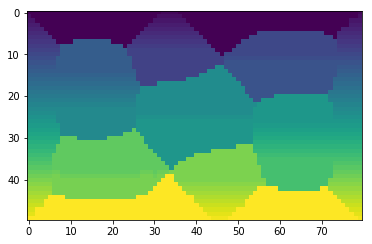

In [5]:
dy = DynamicWindow()
ob = dy.ob

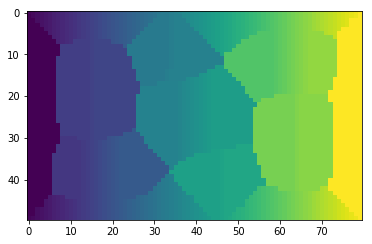

In [6]:
plt.imshow(ob[:,:,0])
plt.show()

In [98]:
gx, gy = 0.5, 1.5
x = np.array([0.5, 0.5, math.pi / 8.0, 0.0, 0.0])
# goal position [x(m), y(m)]
goal = np.array([gx, gy])
# obstacles [x(m) y(m), ....]
ox, oy = [], []
for (c_x, c_y), (w, h) in zip(BORDER_POS, BORDER_BOX):
    for i in np.arange(c_x-w, c_x+w, 1):
        for j in np.arange(c_y-h, c_y+h, 1):
            ox.append(i)
            oy.append(j)
#ob = np.array(ob)
'''
ob = np.array([[-1, -1],
               [0, 2],
               [4.0, 2.0],
               [5.0, 4.0],
               [5.0, 5.0],
               [5.0, 6.0],
               [5.0, 9.0],
               [8.0, 9.0],
               [7.0, 9.0],
               [12.0, 12.0]
               ])
'''

u = np.array([0.0, 0.0])
config = Config()
traj = np.array(x)


0.7254779140278425 0.7893576111161716 [0.5 1.5]
[1.2110679472104842, 0.73, 1.6835549807462364]
0.13780713081359863


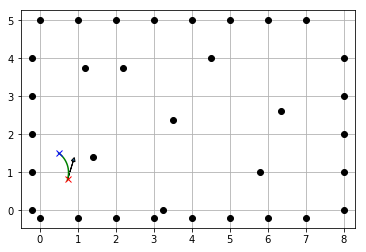

0.7334350171468252 0.8151584736977574 [0.5 1.5]
[0.9244023155149241, 0.74, 1.679858309002751]
0.13553977012634277


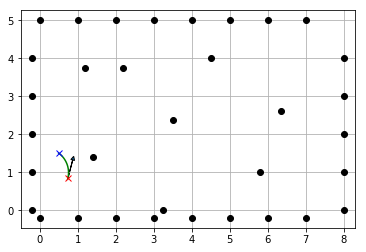

0.7400809940573445 0.8402947222425352 [0.5 1.5]
[0.5450258259237718, 0.75, 1.6739360014916422]
0.14708995819091797


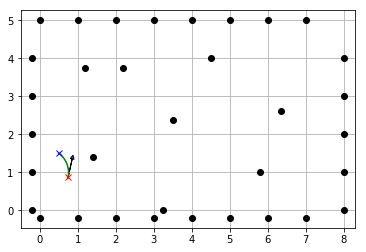

0.7455175408039157 0.8646964426628733 [0.5 1.5]
[0.10581632048303341, 0.76, 1.6658261250471795]
0.14380741119384766


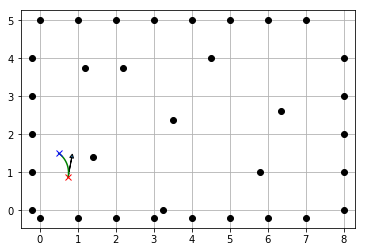

0.7498458802494202 0.8883029137596825 [0.5 1.5]
[0.49993005650329986, 0.77, 1.6392652222989457]
0.13595890998840332


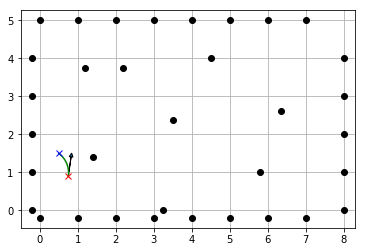

In [103]:
for i in range(5):
    print(x[0], x[1], goal)
    tic = time.time() 
    u, ltraj = dwa_control(x, u, config, goal, ob)
    print(time.time()-tic)

    x = motion(x, u, config.dt)
    traj = np.vstack((traj, x))  # store state history

    # print(traj)
    #print(x, goal, u)

    if show_animation:
        plt.cla()
        plt.plot(ltraj[:, 0], ltraj[:, 1], "-g")
        plt.plot(x[0], x[1], "xr")
        plt.plot(goal[0], goal[1], "xb")
        #plt.imshow(ob[:,:])
        plt.plot(ox, oy, "ok")
        plot_arrow(x[0], x[1], x[2])
        plt.axis("equal")
        plt.grid(True)
        plt.pause(0.0001)


In [104]:
np.save("ob.npy", ob)